# Amazon Food Reviews NLP

This dataset contains raw text reviews of "fine food reviews" from Amazon over more than 10 years.
A product rating is provided as a value between 1 and 5.

## Approach

I'm thinking about three different approaches here.  The first approach is to predict a continous output between 1 and 5 (normalized to 0.2 => 1).  This approach intends for an algorithm to essentially learn review sentiment encoded as this output value. For this approach, I'll explore using neural networks, normalizing the target value and use a sigmoid output function.  I'll compare the results to other regression techniques.

An alternative approach would be to create a binary classifier that predicts discrete values of 0 or 1, considering reviews with 1 and 2 stars as "negative reviews" (0) and 4 or 5 stars as "positive reviews", discarding 3 stars, or randomly sampling 3 star reviews into both positive or negative classes.

A third approach would be to treat the problem as a classification problem, and build a discrete classifier that predicted each review was one of five classes.  This seems most unintuitive, but I suspect that it is worth exploring.  Here, I consider using a CNN to build a classifier with the output as a one-hot encoding of the rating.  Alternatively, I may consider building 5 binary classifiers to distinguish between classes.


In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
import os
import re

import pandas as pd
import seaborn as sns
import matplotlib
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
sns.set(style='dark', palette='muted', font_scale=1.1, rc={'figure.figsize': [16, 6]})

## Raw Data

### Amazon Fine Food Reviews Dataset

Download Amazon Fine Food Reviews Dataset

> https://www.kaggle.com/snap/amazon-fine-food-reviews

In [8]:
DATA_ROOT = 'data'
AMZ_FOOD_DIR = 'amz_fine_food'
AMZ_FOOD_CSV = 'food_reviews.csv'
DATA_AMZ_FOOD = os.path.join(DATA_ROOT, AMZ_FOOD_DIR, AMZ_FOOD_CSV)

In [9]:
df = pd.read_csv(DATA_AMZ_FOOD)
# df = df[:6000]

## Feature Inspection

In [10]:
df.shape

(568454, 10)

In [11]:
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [13]:
col_rename_map = {
    'ProductId': 'product_id',
    'HelpfulnessNumerator': 'helpful_count',
    'HelpfulnessDenominator': 'helpful_total',
    'Score': 'score',
    'Summary': 'summary_text',
    'Text': 'review_text',
    'Time': 'unix_epoch'
}

df.rename(columns=col_rename_map, inplace=True)
df.head(3)

,Id,product_id,UserId,ProfileName,helpful_count,helpful_total,score,unix_epoch,summary_text,review_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


## Target Data Inspection

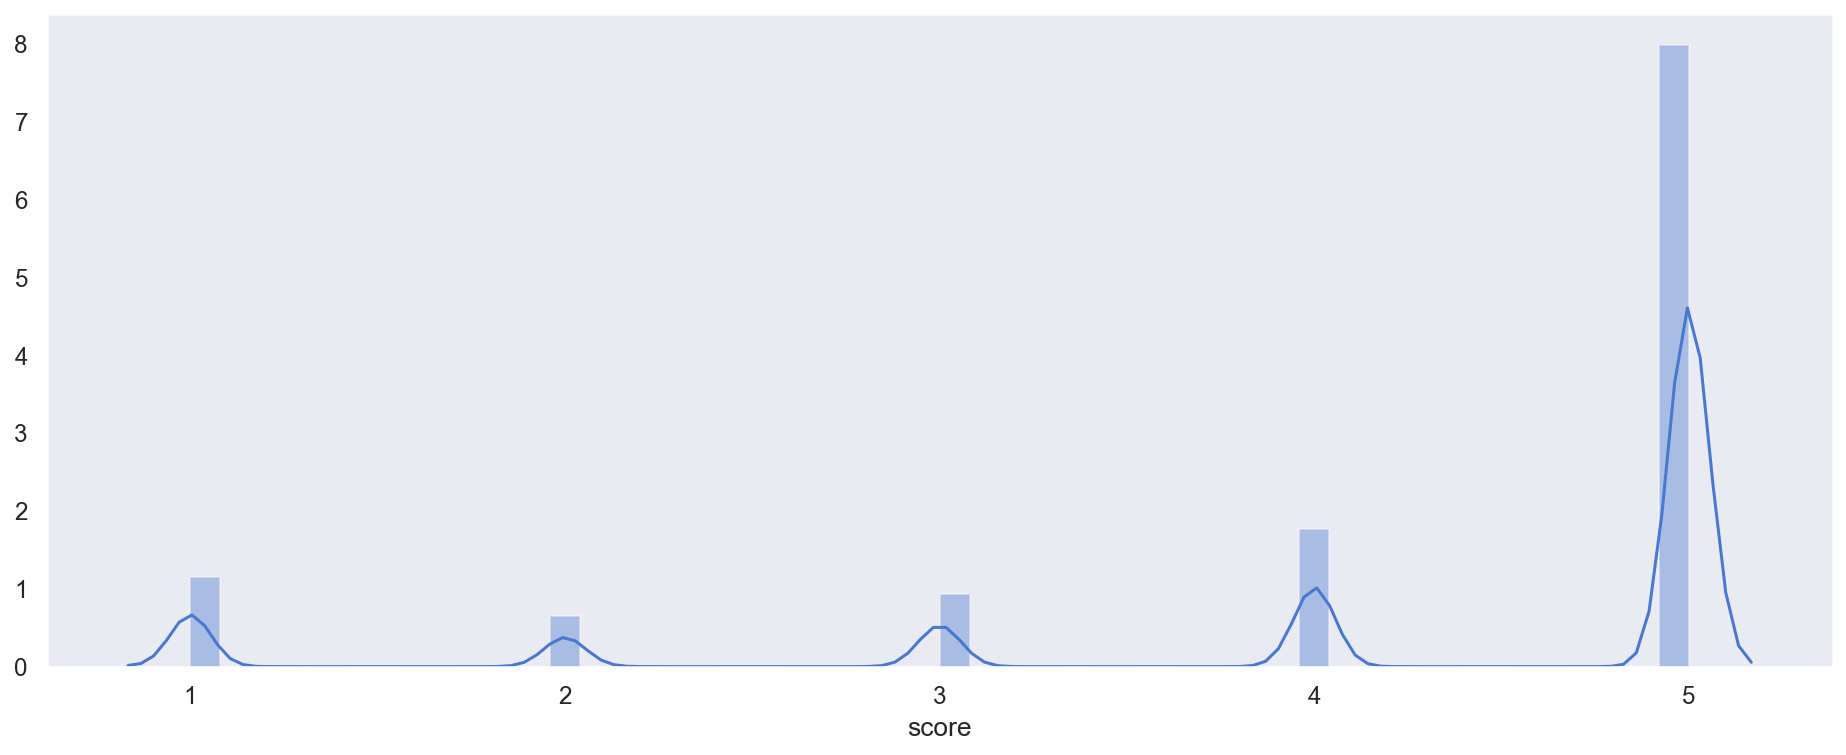

In [14]:
sns.distplot(df.score)

Inspecting the distribution of target values, it's clear that we have heavily imbalanced data.

### The Problem with Imbalanced Classes

Typically, we want balanced classes to train machine learning models. Many algorithms work to maximize accuracy. Think about accuracy as a metric - we could just predict the value of the review to be 5.0 and already achieve ~65% accuracy, much higher than random choice in this case.

### Approaches to rectifying

- undersample majority class
- oversample minority classes
- generate synthetic data

Since the size of the data is small, oversampling minority classes may be a good approach.  I will first explore generating synthetic data using `SMOTE`, or Synthetic Minority Oversampling Technique, which seems interesting.

Reference: https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-14-106

In [15]:
from imblearn.over_sampling import SMOTE

# Will apply resampling after cleaning data and segregating target and features

## Data Preprocessing

In [16]:
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

### Clean Features

- drop irrelevant
- drop duplicates
- convert unix epoch to timestamp
- encode categorical
- handle NaN values

In [17]:
df.drop(['Id', 'UserId', 'ProfileName'], axis=1, inplace=True)

In [18]:
# drop dupes
df = df.drop_duplicates(subset={"product_id","summary_text","unix_epoch","review_text"})
df.shape

(567616, 7)

In [19]:
# convert unix epoch to date type
df['timestamp'] = pd.to_datetime(df['unix_epoch'], unit='s')
df.drop(columns=['unix_epoch'], inplace=True)
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp
0,B001E4KFG0,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,B00813GRG4,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,B000LQOCH0,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18


In [20]:
prod_id_enc = LabelEncoder()
df.product_id = prod_id_enc.fit_transform(df.product_id)
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp
0,27619,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27
1,72383,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07
2,15267,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18


In [21]:
df.isna().sum()
df.dropna(inplace=True)
df.shape

(567589, 7)

## Feature Engineering

Reduce dimensionality by combining `helpful_count` and `helpful_total`

In [22]:
df['helpful_ratio'] = df['helpful_count'] / df['helpful_total']
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp,helpful_ratio
0,27619,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,2011-04-27,1.0
1,72383,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,2012-09-07,NaN
2,15267,1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,2008-08-18,1.0


## Basic text preprocessing

- Normalize
- Stem
- Remove stopwords

In [23]:
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec     


def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

unable to import 'smart_open.gcs', disabling that module


In [24]:
df['summary_text'] = df['summary_text'].astype(str).apply(remove_punctuation).str.lower()
df['review_text'] = df['review_text'].astype(str).apply(remove_punctuation).str.lower()
df[['review_text', 'summary_text']].head(3)

,review_text,summary_text
0,i have bought several of the vitality canned d...,good quality dog food
1,product arrived labeled as jumbo salted peanut...,not as advertised
2,this is a confection that has been around a fe...,delight says it all


In [25]:
snow = SnowballStemmer('english')
stops = stopwords.words('english')

In [26]:
# Tokenize, drop stopwords, stem

def stem_tokenize_sents(sents):
    """
    stems and tokenize list of strings
    drops stop words. returns a tuple 
    of stemmed sents and tokenized stemmed 
    sents
    """
    stemmed_sents = []
    stemmed_tokens = []
    for i, sent in enumerate(sents):
        raw_tokens = sent.split()
        local_tokens = []
        for token in raw_tokens:
            if token not in stops:
                local_tokens.append(snow.stem(token))
        stemmed_tokens.append(local_tokens)
        stemmed_sents.append(' '.join(raw_tokens))
    return stemmed_sents, stemmed_tokens

In [27]:
sents = df['review_text']

# get cleaned sentences as strings and as lilst of tokens
clean_sents, clean_tokenized_sents = stem_tokenize_sents(sents)

In [28]:
df['review_tokens'] = clean_tokenized_sents
df['review_clean'] = clean_sents

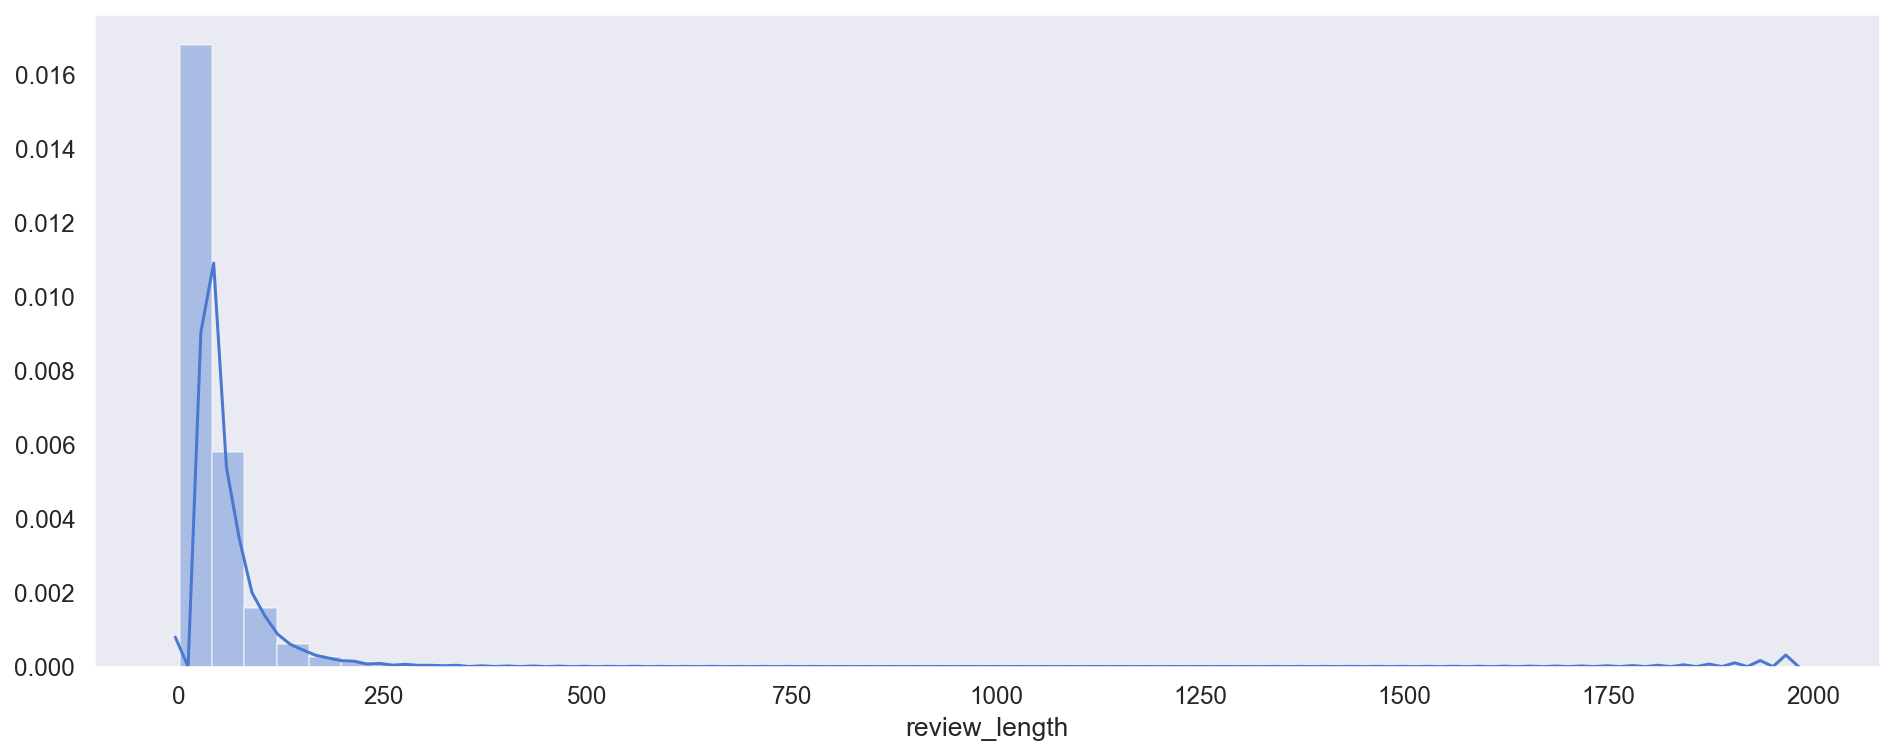

In [29]:
df['review_length'] = df.review_tokens.apply(lambda x: len(x))
sns.distplot(df['review_length'])

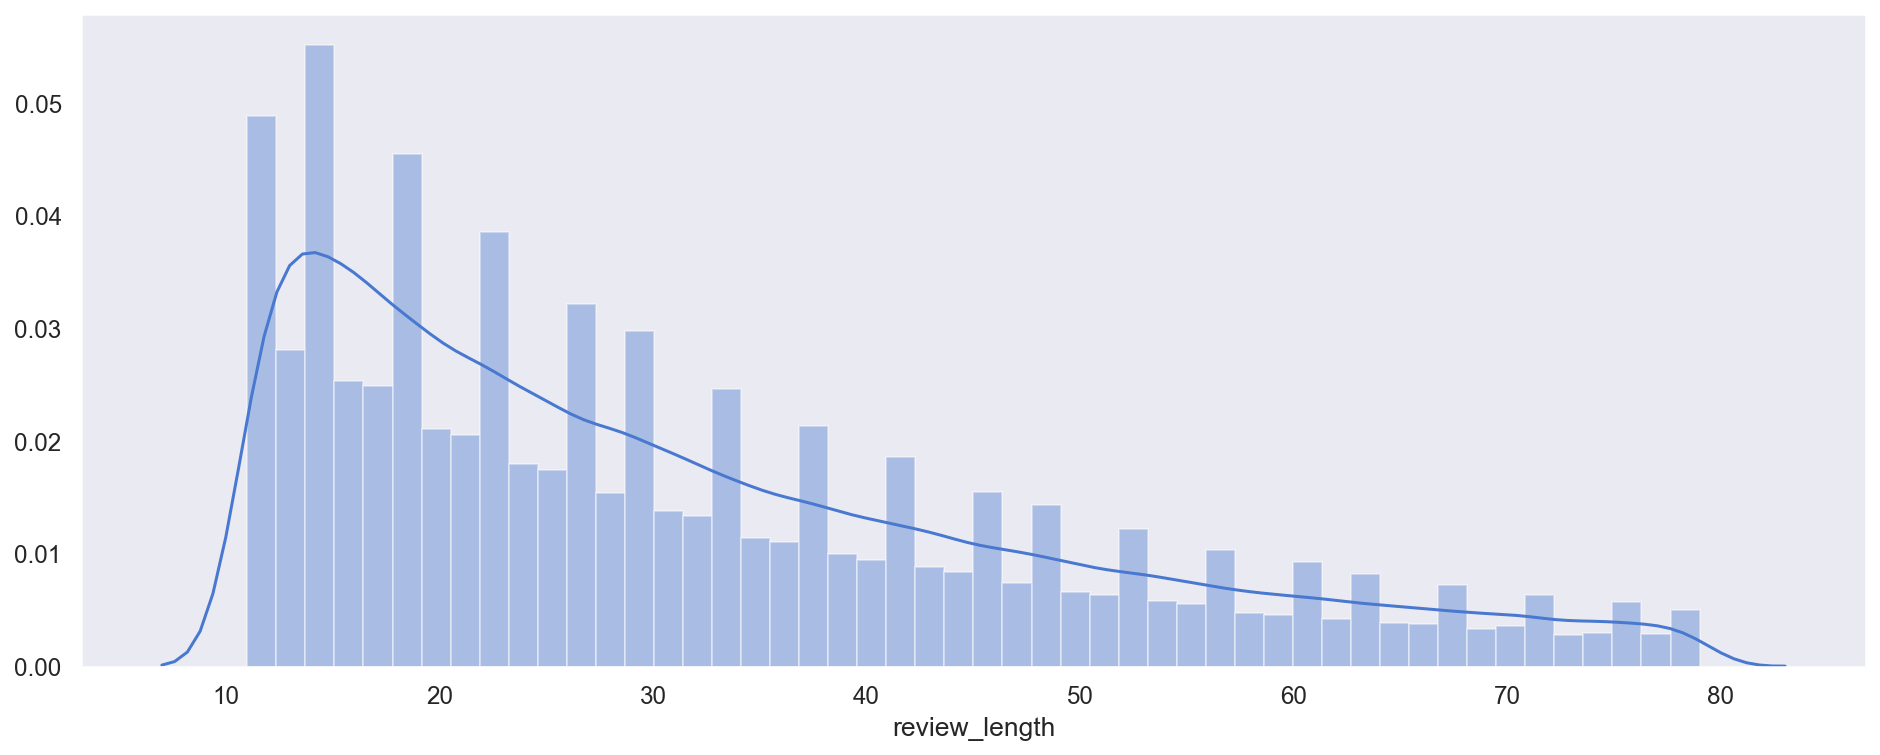

In [30]:
df = df[(df['review_length'] < 80) & (df['review_length'] > 10)]
sns.distplot(df['review_length'])

In [31]:
df.head(3)

,product_id,helpful_count,helpful_total,score,summary_text,review_text,timestamp,helpful_ratio,review_tokens,review_clean,review_length
0,27619,1,1,5,good quality dog food,i have bought several of the vitality canned d...,2011-04-27,1.0,"[bought, sever, vital, can, dog, food, product...",i have bought several of the vitality canned d...,23
1,72383,0,0,1,not as advertised,product arrived labeled as jumbo salted peanut...,2012-09-07,NaN,"[product, arriv, label, jumbo, salt, peanutsth...",product arrived labeled as jumbo salted peanut...,18
2,15267,1,1,4,delight says it all,this is a confection that has been around a fe...,2008-08-18,1.0,"[confect, around, centuri, light, pillowi, cit...",this is a confection that has been around a fe...,40


In [32]:
df.shape

(474216, 11)

## TFIDF Vectors

In [33]:
tf_idf = TfidfVectorizer(binary=True, max_features=6000, min_df=7, max_df=0.8, ngram_range=(1, 3))
tf_data = tf_idf.fit_transform(df['review_clean']).toarray()

In [34]:
tf_idf.vocabulary_['highly recommend']

2211

In [35]:
tf_data[:3]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.14771284,
        0.        ]])

In [36]:
len(tf_idf.vocabulary_)

6000

In [37]:
# each vector is size of vocabulary
i = 0
while i <= 2:
    print(len(tf_data[i]))
    i+=1

6000
6000
6000


In [38]:
# number of records
len(tf_data)

474216

## Split Data

Split data into train and test groups and oversample minority classes using SMOTE

In [39]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample

In [40]:
# look at review length stats by score
df.groupby('score').describe()['review_length']

,count,mean,std,min,25%,50%,75%,max
score,,,,,,,,
1,43945.0,33.351234,17.290502,11.0,19.0,30.0,44.0,79.0
2,24466.0,34.552318,17.655784,11.0,20.0,31.0,46.0,79.0
3,33986.0,34.976373,18.205030,11.0,20.0,31.0,47.0,79.0
4,64520.0,33.755425,18.039756,11.0,18.0,29.0,46.0,79.0
5,307299.0,30.383604,16.711148,11.0,17.0,26.0,40.0,79.0


In [41]:
X_train, X_test, y_train, y_test = train_test_split(tf_data, df.score, test_size=0.2, random_state=8)

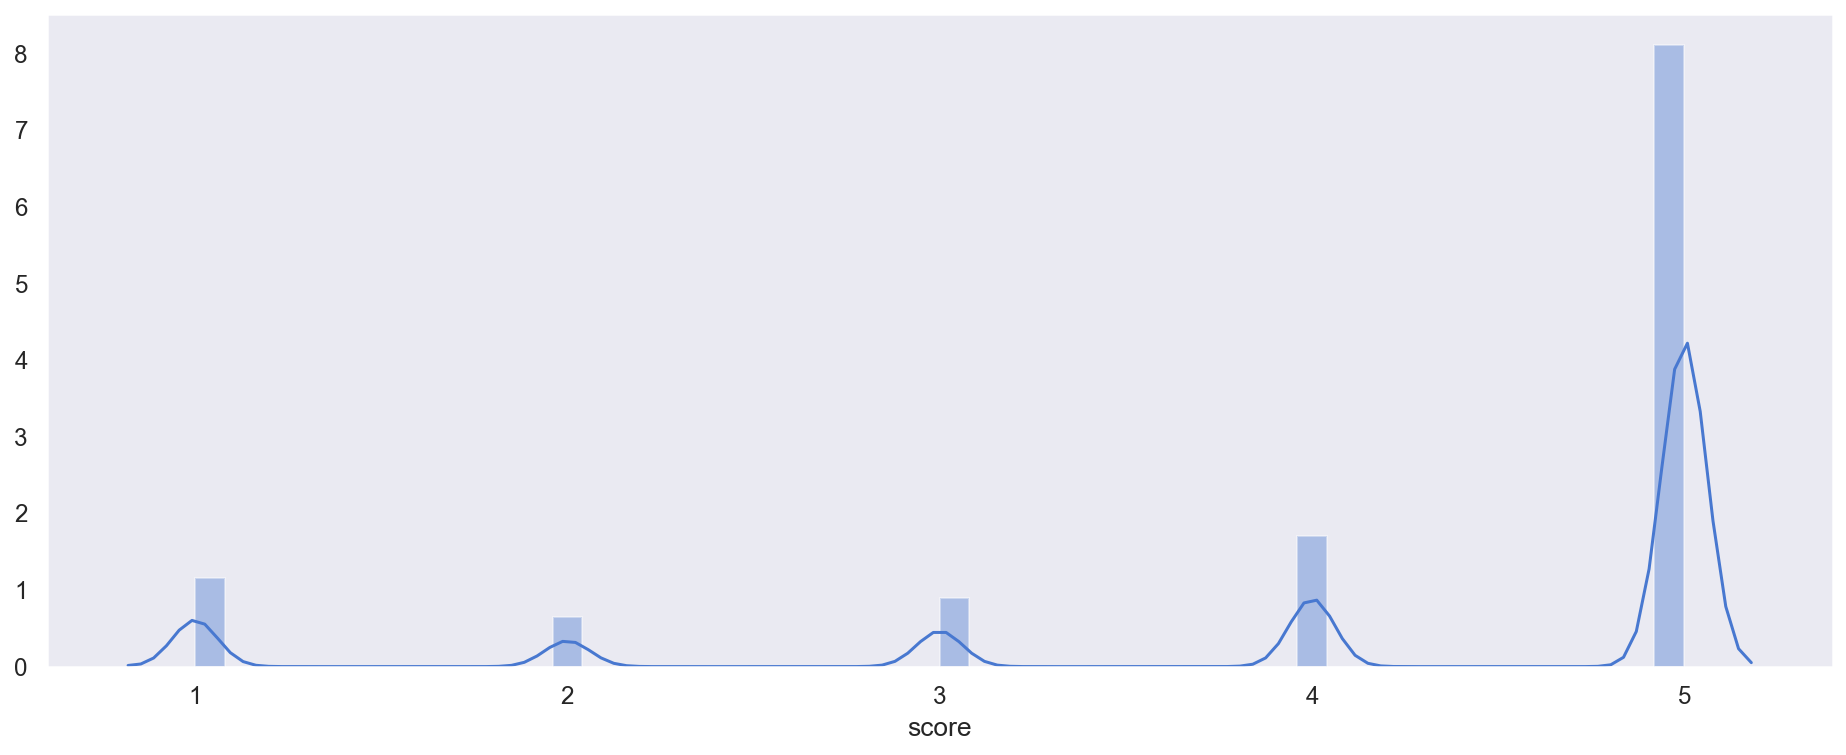

In [42]:
sns.distplot(y_train)

In [1]:
# Use SMOTE for oversampling

oversample = SMOTE()

X_train, y_train = oversample.fit_resample(X_train, y_train)

NameError: name 'SMOTE' is not defined

In [2]:
sns.distplot(y_train)

NameError: name 'sns' is not defined

In [3]:
X_train[1:20]

NameError: name 'X_train' is not defined

In [4]:
print(len(y_train))
print(len(X_train))

NameError: name 'y_train' is not defined

## Classifiers

### Random Forest

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [ ]:
text_classifier = RandomForestClassifier(n_estimators=250, random_state=0)
text_classifier.fit(X_train, y_train)

In [ ]:
# Make predictions on test data
predictions = text_classifier.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predictions)
print('Confusion Matrix')
print(cf_matrix)
print('\n\n')

print('Classification Report')
print(classification_report(y_test, predictions))
print('\n\n')

print('Accuracy')
print(accuracy_score(y_test, predictions))

### Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

In [ ]:
text_classifier = GaussianNB()
text_classifier.fit(X_train, y_train)

In [ ]:
predictions = text_classifier.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression(C=1e5)
logreg.fit(X_train, y_train)

In [ ]:
predictions = logreg.predict(X_test)

In [ ]:
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

## Neural Network Approaches

### Neural Network, basic multilayer perceptron with Dropout, discrete output

In [49]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.initializers import he_normal, RandomNormal

In [50]:
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=len(tf_idf.vocabulary_)))
model.add(Dropout(0.5))
model.add(Dense(250, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               600100    
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               25250     
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               128512    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

#### One-hot encode target for NN

In [52]:
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [53]:
lb = LabelEncoder()
y = lb.fit_transform(y_train)
y = to_categorical(y)

In [54]:
y[:3]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [55]:
y.shape

(379372, 5)

In [56]:
y_0 = lb.fit_transform(y_test)
y_0 = to_categorical(y_0)

In [57]:
# Train the model, iterating on the data in batches of 32 samples
history = model.fit(X_train, y, validation_data=(X_test, y_0), epochs=20, batch_size=16)

Train on 379372 samples, validate on 94844 samples
Epoch 1/20
379372/379372 [==============================] - 129s 339us/sample - loss: 0.7618 - accuracy: 0.7226 - val_loss: 0.6979 - val_accuracy: 0.7493
Epoch 2/20
379372/379372 [==============================] - 133s 350us/sample - loss: 0.6975 - accuracy: 0.7467 - val_loss: 0.6800 - val_accuracy: 0.7498
Epoch 3/20
379372/379372 [==============================] - 122s 320us/sample - loss: 0.6799 - accuracy: 0.7556 - val_loss: 0.6681 - val_accuracy: 0.7665
Epoch 4/20
379372/379372 [==============================] - 127s 334us/sample - loss: 0.6685 - accuracy: 0.7621 - val_loss: 0.6570 - val_accuracy: 0.7672
Epoch 5/20
379372/379372 [==============================] - 149s 394us/sample - loss: 0.6594 - accuracy: 0.7662 - val_loss: 0.6639 - val_accuracy: 0.7730
Epoch 6/20
379372/379372 [==============================] - 155s 408us/sample - loss: 0.6606 - accuracy: 0.7694 - val_loss: 0.7237 - val_accuracy: 0.7740
Epoch 7/20
379372/379372 

In [58]:
model.save_weights("tf_amz_food_model_01.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


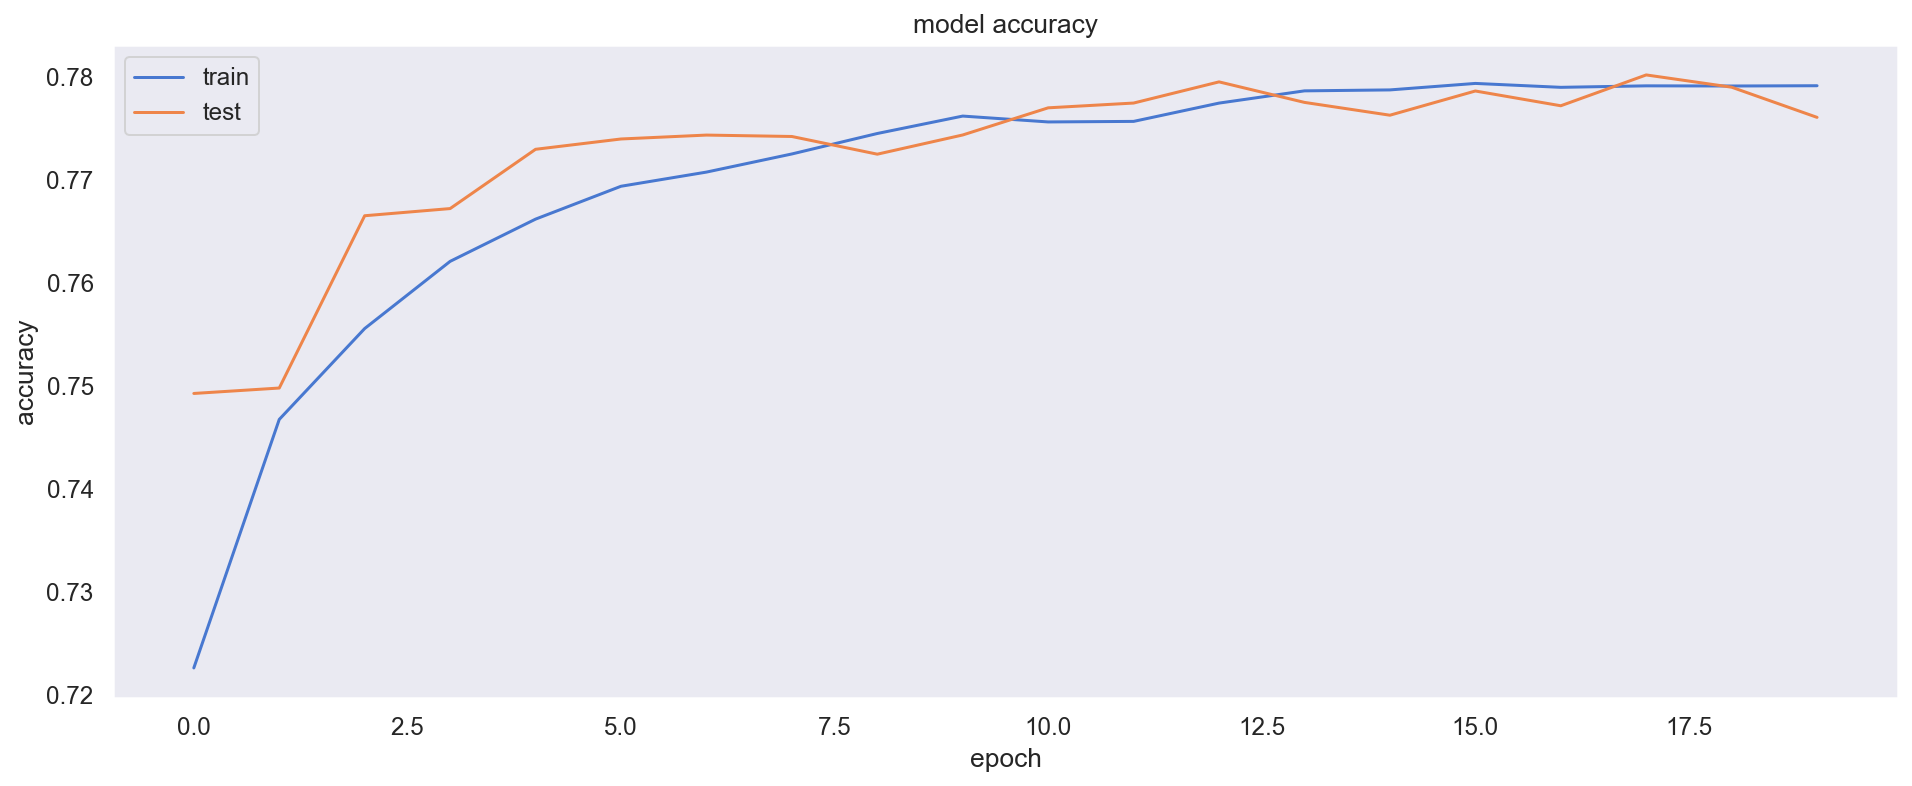

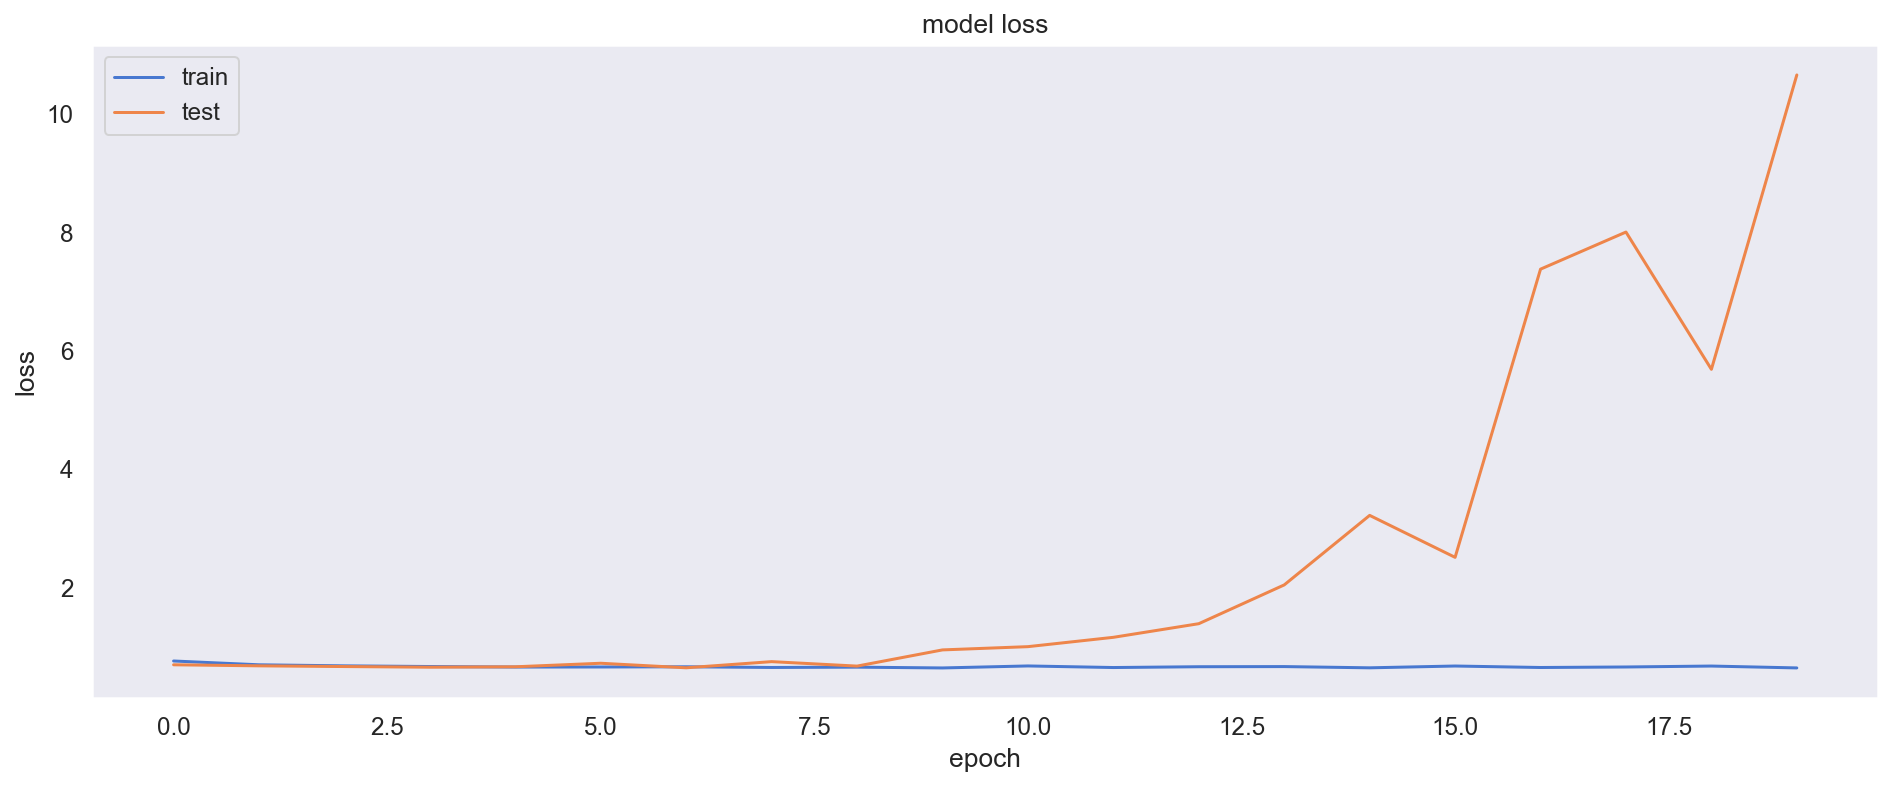

In [59]:
print(history.history.keys())
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Neural Network, basic multilayer perceptron with Dropout, continuous output

In [60]:
from tensorflow.keras.optimizers import RMSprop

optimizer = RMSprop(0.001)
    
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=len(tf_idf.vocabulary_)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

In [61]:
y_train[:8]

157986    5
169287    5
413872    5
111059    3
552489    5
175835    5
86080     2
348882    5
Name: score, dtype: int64

In [62]:
y_train_cont = np.true_divide(y_train, 5).to_numpy()
y_train_cont[:8]

array([1. , 1. , 1. , 0.6, 1. , 1. , 0.4, 1. ])

In [63]:
y_1 = np.true_divide(y_test, 5).to_numpy()
y_1[:8]

array([1. , 0.8, 0.8, 1. , 0.6, 1. , 1. , 1. ])

In [64]:
history = model.fit(X_train, y_train_cont, validation_data=(X_test, y_1), epochs=3, batch_size=16)

Train on 379372 samples, validate on 94844 samples
Epoch 1/3
379372/379372 [==============================] - 89s 235us/sample - loss: 0.0265 - mse: 0.0265 - val_loss: 0.0236 - val_mse: 0.0236
Epoch 2/3
379372/379372 [==============================] - 87s 230us/sample - loss: 0.0210 - mse: 0.0210 - val_loss: 0.0216 - val_mse: 0.0216
Epoch 3/3
379372/379372 [==============================] - 88s 232us/sample - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0216 - val_mse: 0.0216


In [ ]:
act = y_1[7:20]

In [ ]:
res = model.predict(X_test)

In [ ]:
sns.scatterplot(y_1.flatten(), res.flatten())
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")

In [ ]:
print(history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Sentiment Analysis

### Crude Sentiment Analysis

In [ ]:
positive_words = [
    'good', 'great', 'love', 'loved', 'fantastic', 
    'delicious', 'excellent', 'satisfied', 'well', 'nice', 
    'perfect', 'perfectly', 'thanks', 'thank', 'tasty', 'fun'
]

negative_words = [
    'bad', 'horrible', 'disappointed', 'damaged', 
    'terrible', 'hate', 'garbage', 'worthless',
    'cheap', 'wrong', 'frustrating', 'frustrated',
    'disgusting', 'gross', 'horrible', 'nasty',
    'spoiled', 'stale', 'watery'
]

def sum_count_in_list(words, word_list):
    count = 0
    for word in words:
        if word in word_list:
            count += 1
    return count

In [ ]:
df['pos_word_count'] = df['review_tokens'].apply(lambda x: sum_count_in_list(x, positive_words))
df['neg_word_count'] = df['review_tokens'].apply(lambda x: sum_count_in_list(x, negative_words))

In [ ]:
df.head(3)

In [ ]:
df_corr = df[['pos_word_count', 'neg_word_count', 'review_length', 'score']].corr()
df_corr

In [ ]:
sns.heatmap(df_corr, annot=True)